In [3]:
!wget https://machinehack-be.s3.amazonaws.com/fake_news_content_detection_weekend_hackathon_20/Participants_Data_WH20.zip

--2020-09-13 19:09:13--  https://machinehack-be.s3.amazonaws.com/fake_news_content_detection_weekend_hackathon_20/Participants_Data_WH20.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.66.60
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.66.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565484 (552K) [application/zip]
Saving to: ‘Participants_Data_WH20.zip.1’

Participants_Data_W 100%[===================>] 552.23K   469KB/s    in 1.2s    

2020-09-13 19:09:15 (469 KB/s) - ‘Participants_Data_WH20.zip.1’ saved [565484/565484]



In [4]:
!unzip Participants_Data_WH20.zip

Archive:  Participants_Data_WH20.zip
replace Participants_Data_WH20/sample submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Participants_Data_WH20/sample submission.csv  
  inflating: __MACOSX/Participants_Data_WH20/._sample submission.csv  
  inflating: Participants_Data_WH20/Test.csv  
  inflating: __MACOSX/Participants_Data_WH20/._Test.csv  
  inflating: Participants_Data_WH20/Train.csv  
  inflating: __MACOSX/Participants_Data_WH20/._Train.csv  


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from fastai.text import *
from fastai.imports import *
from fastai.text import *
from fastai import *
path = Path('/content/Participants_Data_WH20/')
path.ls()
%matplotlib inline

from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *
from catboost import CatBoostClassifier
import nltk
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

In [6]:
train = pd.read_csv('Participants_Data_WH20/Train.csv')
test = pd.read_csv('Participants_Data_WH20/Test.csv')
sub=pd.read_csv('Participants_Data_WH20/sample submission.csv')

In [7]:
train.head(5)

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


In [8]:
test.head(5)

,Text,Text_Tag
0,Building a wall on the U.S.-Mexico border will...,immigration
1,Wisconsin is on pace to double the number of l...,jobs
2,Says John McCain has done nothing to help the ...,"military,veterans,voting-record"
3,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti..."
4,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti..."


In [9]:
train['Text_Tag']=train['Text_Tag'].fillna(method='bfill')

# noe

In [10]:
df=train.append(test,ignore_index=True)

In [11]:
df['exam']=df['Text']+df['Text_Tag']

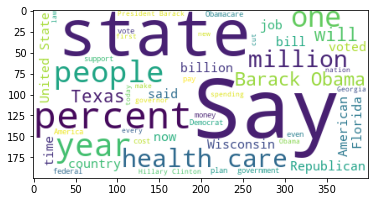

In [12]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(df['Text']))
plt.imshow(wc)

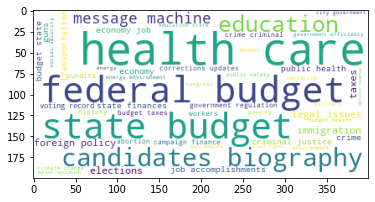

In [13]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(df['Text_Tag']))
plt.imshow(wc)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
cvec = TfidfVectorizer(max_features=10000, norm = 'l1', lowercase=True, smooth_idf=False, sublinear_tf=False, ngram_range=(1,4), tokenizer=TreebankWordTokenizer().tokenize)
df_info = pd.DataFrame(cvec.fit_transform(df['Text']).todense())
df_info.columns = ['Text_Top_' + str(c) for c in df_info.columns]
df = pd.concat([df, df_info], axis=1)

In [15]:
m=[]
c=0
for i in df['Text_Tag']:
  x=i.strip().split(',')
  for i in x:
    if i in m:
      pass
    else:
      m.append(i)
len(m)

144

In [16]:
x = df['Text_Tag'].str.split(',').apply(Series, 1)
x=x.fillna('zero')

In [17]:
df['Test_tag_0']=x[0]
df['Test_tag_1']=x[1]
df['Test_tag_2']=x[2]

In [18]:
import string
punctuation=string.punctuation
df['numerics'] = df['Text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['Text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df['punctuation_count'] = df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))

In [19]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['Text'] = df['Text'].apply(clean_text)

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
import string
punctuation=string.punctuation
df['word_count']=df['Text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['Text'].str.len()
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['Text'].apply(lambda x: avg_word(x))
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['Text'].apply(lambda x: len([x for x in x.split() if x in stop]))

df['word_density'] = df['char_count'] / (df['word_count']+1)


In [22]:
j=[]
for i in df['Text']:
  j.append(len(i))
df['len']=j
j=[]
for i in df['Text_Tag']:
  j.append(len(i))
df['Text_Tag_len']=j

In [23]:
df['Text_Tag_word_count']=df['Text_Tag'].apply(lambda x: len(str(x).split(",")))

In [24]:
from textblob import TextBlob
df['polarity'] = df.apply(lambda x: TextBlob(x['Text']).sentiment.polarity, axis=1)
df['subjectivity'] = df.apply(lambda x: TextBlob(x['Text']).sentiment.subjectivity, axis=1)

In [25]:
del df['Text']
del df['Text_Tag']

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Test_tag_0'] = le.fit_transform(df['Test_tag_0'])
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Test_tag_1'] = le.fit_transform(df['Test_tag_1'])
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Test_tag_2'] = le.fit_transform(df['Test_tag_2'])

In [27]:
train = df[df['Labels'].isnull()==False]
test = df[df['Labels'].isnull()==True]
del test['Labels']

#algoex

In [28]:
train_df=train
test_df=test

In [29]:
 X = train_df.drop(labels=['Labels'], axis=1)
y = train_df['Labels'].values

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

In [31]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((9216, 10017), (9216,), (1024, 10017), (1024,))

In [32]:
from sklearn.metrics import log_loss

In [33]:

import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 6,
         'boosting': 'dart',  
         'metric': 'multi_logloss',
         'learning_rate': 0.01, 
         'num_iterations': 1000,
         'num_leaves': 31,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 2,
         'feature_fraction': 0.9,
         'lambda_l2': 0.9,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':True,
         'task_type':'GPU'
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


ValueError: ignored

In [1]:
log_loss(y_cv, y_pred)

NameError: ignored

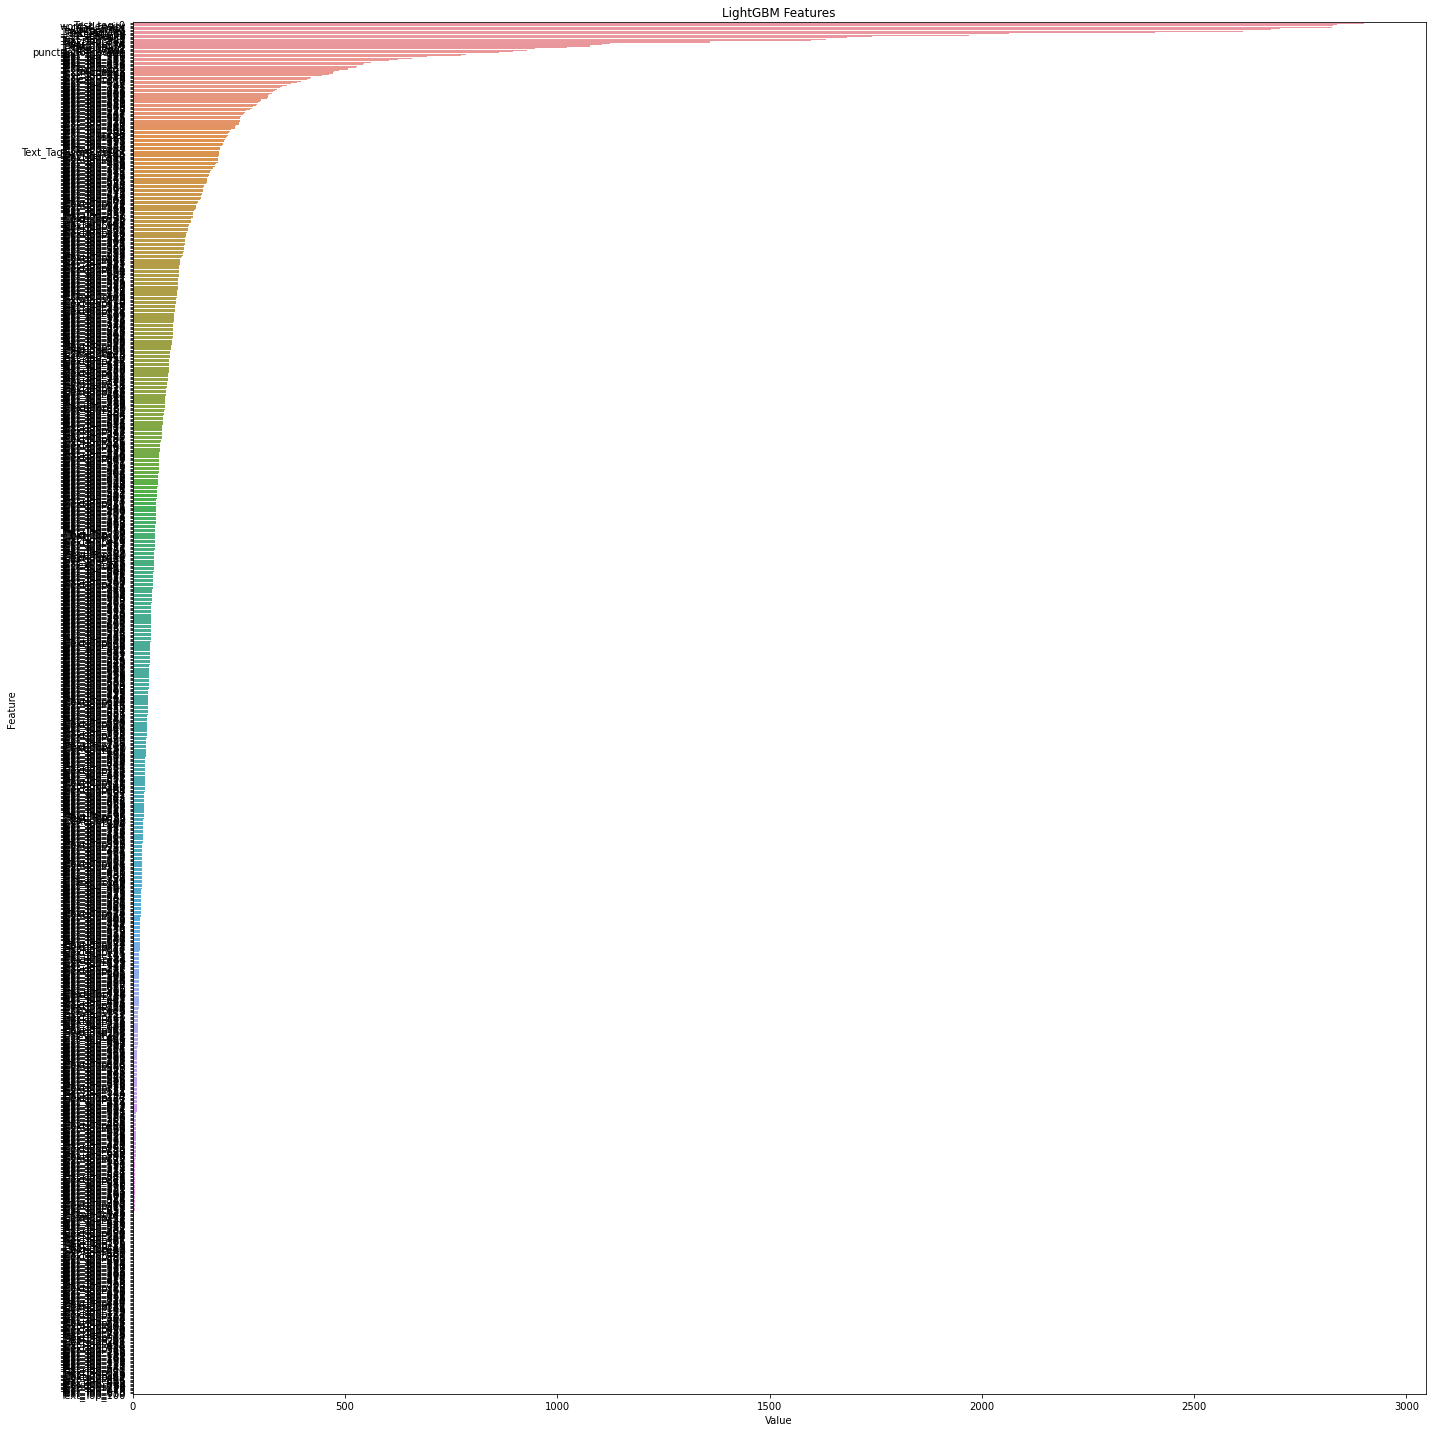

In [122]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [123]:
Xtest = test_df

In [124]:

from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.73013
[200]	valid_0's multi_logloss: 1.72039
[300]	valid_0's multi_logloss: 1.71834
[400]	valid_0's multi_logloss: 1.72004
Early stopping, best iteration is:
[287]	valid_0's multi_logloss: 1.71815
Log Loss:  1.7181478505835641


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.73083
[200]	valid_0's multi_logloss: 1.72711
[300]	valid_0's multi_logloss: 1.72616
[400]	valid_0's multi_logloss: 1.73134
Early stopping, best iteration is:
[240]	valid_0's multi_logloss: 1.72552
Log Loss:  1.7255236794866247


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.72012
[200]	valid_0's multi_logloss: 1.70621
[300]	valid_0's multi_logloss: 1.70235
[400]	valid_0's multi_logloss: 1.70356
[500]	valid_0's multi_logloss: 1.70902
Did not meet early stopping. Best iteration is:
[304]	valid_0's multi_logloss: 1.70226
Log Loss:  1.7022560169312189


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.72582
[200]	valid_0's multi_logloss: 1.71428
[300]	valid_0's multi_logloss: 1.71026
[400]	valid_0's multi_logloss: 1.71287
[500]	valid_0's multi_logloss: 1.71827
Did not meet early stopping. Best iteration is:
[303]	valid_0's multi_logloss: 1.71008
Log Loss:  1.7100752745039807


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.73248
[200]	valid_0's multi_logloss: 1.72298
[300]	valid_0's multi_logloss: 1.72057
[400]	valid_0's multi_logloss: 1.72093
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 1.72027
Log Loss:  1.7202683973214021


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.72301
[200]	valid_0's multi_logloss: 1.70809
[300]	valid_0's multi_logloss: 1.70376
[400]	valid_0's multi_logloss: 1.70517
Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 1.70346
Log Loss:  1.703458391475452


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.73131
[200]	valid_0's multi_logloss: 1.72325
[300]	valid_0's multi_logloss: 1.72302
[400]	valid_0's multi_logloss: 1.7255
Early stopping, best iteration is:
[234]	valid_0's multi_logloss: 1.72219
Log Loss:  1.722189148564922


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.73432
[200]	valid_0's multi_logloss: 1.72985
[300]	valid_0's multi_logloss: 1.73018
[400]	valid_0's multi_logloss: 1.73552
Early stopping, best iteration is:
[263]	valid_0's multi_logloss: 1.72934
Log Loss:  1.7293379690216366


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.73709
[200]	valid_0's multi_logloss: 1.73305
[300]	valid_0's multi_logloss: 1.73663
Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 1.7327
Log Loss:  1.7327032839511012


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.73609
[200]	valid_0's multi_logloss: 1.72906
[300]	valid_0's multi_logloss: 1.73063
[400]	valid_0's multi_logloss: 1.73683
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 1.72891
Log Loss:  1.7289067038384032


In [125]:
np.mean(errlgb,0)

1.7192866715678305

In [126]:
y_pred = np.mean(y_pred_totlgb,0)

In [131]:
submission = pd.DataFrame(data=y_pred*1.0027, columns=sub.columns)
submission.head()

,0,1,2,3,4,5
0,0.219771,0.189428,0.129937,0.180588,0.180259,0.102718
1,0.106062,0.212814,0.123400,0.184403,0.126627,0.249394
2,0.147998,0.224756,0.177558,0.162423,0.096047,0.193919
3,0.196707,0.270586,0.265664,0.128152,0.059548,0.082042
4,0.178497,0.268788,0.206407,0.141625,0.097593,0.109790


In [132]:
submission.to_csv('multi.csv', index=False)

# r1

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

In [79]:
TARGET_COL ='Labels'
train, test = df.iloc[:train.shape[0]], df.iloc[train.shape[0]:]
test.reset_index(drop=True, inplace=True)
target = train[TARGET_COL]
features = [c for c in train.columns if c not in [TARGET_COL]]

In [80]:
X_trn, X_val, y_trn, y_val = train_test_split(train[features], target, test_size=0.10, stratify=target, random_state=101)
X_test = test[features]

In [81]:
clf = LGBMClassifier(boosting='gbdt',learning_rate=0.01, n_estimators=1000,num_leaves=31)
_ = clf.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=100, early_stopping_rounds=100)
predictions_val_lgb = clf.predict_proba(X_val)
print(f"Log loss for Model 1 is: {log_loss(y_val, predictions_val_lgb)}")

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.64679	valid_1's multi_logloss: 1.72963
[200]	training's multi_logloss: 1.56291	valid_1's multi_logloss: 1.72068
[300]	training's multi_logloss: 1.49332	valid_1's multi_logloss: 1.71957
[400]	training's multi_logloss: 1.43389	valid_1's multi_logloss: 1.72271
Early stopping, best iteration is:
[308]	training's multi_logloss: 1.48834	valid_1's multi_logloss: 1.71956
Log loss for Model 1 is: 1.7195587965376684


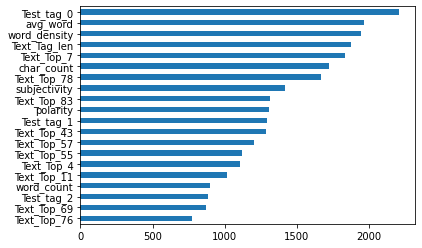

In [82]:
fi = pd.Series(index=features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[:20][::-1].plot.barh()

In [83]:
predictions_test_lgb = clf.predict_proba(X_test)

In [84]:
submission = pd.DataFrame(data=predictions_test_lgb, columns=sub.columns)
submission.head()

,0,1,2,3,4,5
0,0.132926,0.316492,0.176817,0.162578,0.065069,0.146119
1,0.091444,0.219297,0.188594,0.220669,0.062961,0.217034
2,0.139330,0.248671,0.206724,0.172965,0.100835,0.131474
3,0.196269,0.274059,0.169233,0.165142,0.086859,0.108438
4,0.164528,0.174057,0.213079,0.234513,0.072365,0.141457


In [85]:
submission.to_csv('Mh01.csv', index=False)

# roberta

In [26]:
df = pd.concat([train, test]).reset_index()

In [27]:
word_embeddings = SentenceTransformer('roberta-large-nli-stsb-mean-tokens').encode(df.exam)

100%|██████████| 1.31G/1.31G [01:06<00:00, 19.8MB/s]


In [28]:
word_embeddings = pd.DataFrame(data=word_embeddings)
word_embeddings.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.801883,0.511661,0.272893,0.441221,0.463626,0.331225,1.214009,-0.217106,-1.140216,0.282758,-0.975920,-1.419697,0.257403,0.735011,-0.292063,-1.615715,0.647413,-0.322343,0.234186,-0.757872,-0.895169,-0.723663,-1.180914,-1.058129,0.107446,-0.295619,-0.030847,-0.401780,-0.584536,-0.051050,0.399052,-0.852768,0.208489,0.085622,-1.578175,-0.531752,0.323392,-0.784022,-1.496740,-0.645368,...,-0.302775,-0.282882,-0.077527,0.095239,-1.039294,-0.090900,-0.083196,0.266914,-0.021078,-0.222481,0.660045,-0.989475,-0.335516,-1.918082,-0.517694,0.555794,0.570587,-0.506178,0.027676,0.710457,-0.016272,0.049623,1.238207,-0.305549,-0.579361,-1.146383,0.463412,-0.265080,-1.001871,1.359082,0.188887,0.456408,0.904822,0.546142,0.018217,0.618712,-0.471544,0.772706,-0.635814,-0.327403
1,-0.065657,0.937802,1.334514,0.252647,0.394274,-0.679673,-1.148281,-0.144142,0.803068,-0.548930,0.411720,-0.266884,-0.238542,-0.182003,-0.235795,-0.725057,-0.645538,-0.224459,0.307029,-0.041149,0.300311,0.410458,-0.641302,0.083911,-0.996734,0.115280,-0.810110,-1.124860,0.300343,-1.099083,0.574459,0.336379,-0.708229,-0.272053,0.623871,-0.752064,-0.442056,0.020547,1.474250,-0.719255,...,0.458236,0.177231,-0.166351,-0.651130,0.737427,-0.232309,-0.295287,-0.292511,-0.728357,-1.053575,0.950193,-1.327629,-0.453734,-0.291895,0.790298,-0.293105,-1.869508,-0.359968,-0.203410,-0.864321,0.410455,-0.794275,-0.518989,0.027805,-0.924352,-1.544062,-0.777510,0.868630,-1.569012,0.082370,-0.778777,1.001443,-0.548175,1.132127,-0.192424,0.405482,-0.349500,-0.508972,-1.854057,0.005836
2,-1.164357,-0.756229,-0.253541,-1.411964,0.155720,-0.192438,-0.593016,1.088283,-0.449267,0.442307,-0.480819,-0.706141,-1.049064,1.032293,0.528963,-0.105588,1.321583,0.921122,0.694375,0.951267,-0.199727,-1.014720,-1.735588,-0.202829,-0.537754,0.220931,0.235791,-0.199278,-0.624736,-0.434325,-1.203798,-1.079593,0.613384,1.088589,-0.942701,-1.217841,0.338625,-0.038331,-1.181492,0.413882,...,0.527184,-0.454275,-0.551556,0.553771,0.398279,1.730838,-0.321381,-0.387629,0.268391,-0.206483,0.678006,0.613707,-0.578744,1.792660,-0.546838,0.317672,0.098957,0.240118,-1.008545,-0.062218,-1.190836,0.472364,0.104265,-1.138334,0.543779,0.254874,-0.040282,0.654161,-0.671741,1.429626,0.619683,1.391288,-0.416964,0.170247,-0.953644,0.235321,-0.963672,-1.880567,0.216914,-0.230296
3,0.600805,0.505085,0.603590,0.511605,0.775266,-0.093028,0.290949,-0.318093,-0.437430,0.000395,-0.157860,1.707440,-0.377165,0.479488,-0.379611,-1.269664,-0.253589,0.001603,-0.821549,-1.291210,-0.075261,0.797197,1.674821,-0.465363,1.328702,-0.341335,-0.524673,-0.435174,0.837961,-0.684701,-1.316985,-0.401352,-0.583970,0.428655,-0.697539,0.679382,-0.747504,-0.830236,-0.373260,-0.192130,...,-0.201329,-0.406040,-0.187641,-0.489907,-0.223781,0.547441,0.741735,0.828914,-0.946390,-0.166673,0.527885,-0.671121,-1.212912,-0.777085,-0.556243,0.016882,0.026109,-0.821794,-1.126272,-0.728123,-0.608869,-1.651639,1.132287,-0.130393,0.659210,-0.361745,0.981023,-0.330118,-1.503566,1.950964,0.249735,-0.106412,-0.412975,0.098251,0.806665,-0.225918,-0.068621,1.446685,0.781926,-0.499272


In [29]:
from sklearn.decomposition import PCA
pca = pd.DataFrame(data=PCA(10).fit_transform(word_embeddings), columns=[f'pca{i}' for i in range(1,11)])

In [30]:
df['Length'] = df['exam'].apply(len)
df = pd.concat([df.drop('exam', axis=1), word_embeddings, pca], axis=1)
df.head(4)

,index,Labels,Text_Top_0,Text_Top_1,Text_Top_2,Text_Top_3,Text_Top_4,Text_Top_5,Text_Top_6,Text_Top_7,Text_Top_8,Text_Top_9,Text_Top_10,Text_Top_11,Text_Top_12,Text_Top_13,Text_Top_14,Text_Top_15,Text_Top_16,Text_Top_17,Text_Top_18,Text_Top_19,Text_Top_20,Text_Top_21,Text_Top_22,Text_Top_23,Text_Top_24,Text_Top_25,Text_Top_26,Text_Top_27,Text_Top_28,Text_Top_29,Text_Top_30,Text_Top_31,Text_Top_32,Text_Top_33,Text_Top_34,Text_Top_35,Text_Top_36,Text_Top_37,...,pca961,pca962,pca963,pca964,pca965,pca966,pca967,pca968,pca969,pca970,pca971,pca972,pca973,pca974,pca975,pca976,pca977,pca978,pca979,pca980,pca981,pca982,pca983,pca984,pca985,pca986,pca987,pca988,pca989,pca990,pca991,pca992,pca993,pca994,pca995,pca996,pca997,pca998,pca999,pca1000
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023809,0.184734,0.093773,0.030854,-0.010382,-0.040800,-0.047846,0.074355,-0.017982,-0.010012,-0.039856,-0.063670,0.078074,0.042075,0.036134,0.157250,-0.004888,0.003015,0.095547,-0.017156,0.072240,0.010352,-0.168875,0.017262,-0.002630,0.102842,-0.011804,-0.081018,-0.011618,0.042732,-0.001464,-0.043880,0.096391,0.093853,-0.080673,-0.060186,0.112491,-0.001261,0.061843,0.120300
1,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077225,-0.060260,-0.104936,-0.107907,0.076472,-0.162036,-0.065965,-0.024900,-0.079201,0.067747,-0.076460,-0.196543,0.037028,0.082739,-0.049011,0.032540,-0.132201,-0.000360,-0.022337,-0.038148,-0.085780,0.006288,-0.074732,-0.064538,0.131269,-0.080810,0.040024,0.050213,0.084073,-0.018483,-0.046730,-0.011207,-0.195305,-0.002421,-0.097465,-0.028483,-0.059795,-0.103951,0.085372,-0.052157
2,2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.037645,0.053626,0.044438,0.076664,0.002145,-0.051960,0.008248,0.025148,0.000114,0.087067,-0.055219,0.001987,0.119827,-0.046102,0.119273,0.065535,0.051255,-0.090670,-0.073593,0.052585,0.013812,-0.022018,0.045060,-0.063626,0.072032,-0.045163,0.075317,-0.181806,-0.096549,-0.023779,-0.077321,0.075393,0.025453,-0.047526,-0.041880,0.015985,-0.044579,-0.045965,0.029653,-0.008133
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.089885,-0.009769,-0.028286,0.042529,0.140157,-0.078353,-0.160066,0.009059,0.137557,-0.122069,0.097059,-0.140539,0.060592,-0.103793,-0.133793,0.024419,-0.092305,0.167432,-0.061101,0.067233,-0.150801,-0.044584,0.098918,0.032599,0.131059,0.004597,0.063609,0.063597,0.041731,-0.063226,-0.029099,-0.086719,0.111554,-0.133897,0.049291,-0.061517,0.005382,0.096425,-0.026016,-0.007693


In [31]:
train_df = df[df.Labels.notnull()]
test_df = df[df.Labels.isnull()]

In [32]:
X, y = train_df.drop(['index','Labels'], axis=1), train_df.Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [33]:

model_cat = CatBoostClassifier(od_type='Iter', iterations=10000, task_type='GPU')
model_cat.fit(X_train, y_train.astype(int),
              eval_set=(X_test, y_test.astype(int)),
              early_stopping_rounds=100,
)

Learning rate set to 0.048112
0:	learn: 1.7869498	test: 1.7874637	best: 1.7874637 (0)	total: 322ms	remaining: 53m 35s
1:	learn: 1.7816338	test: 1.7831967	best: 1.7831967 (1)	total: 459ms	remaining: 38m 12s
2:	learn: 1.7768357	test: 1.7786288	best: 1.7786288 (2)	total: 591ms	remaining: 32m 49s
3:	learn: 1.7717630	test: 1.7747588	best: 1.7747588 (3)	total: 727ms	remaining: 30m 16s
4:	learn: 1.7676934	test: 1.7710834	best: 1.7710834 (4)	total: 826ms	remaining: 27m 30s
5:	learn: 1.7634968	test: 1.7683797	best: 1.7683797 (5)	total: 960ms	remaining: 26m 38s
6:	learn: 1.7593287	test: 1.7651303	best: 1.7651303 (6)	total: 1.09s	remaining: 25m 58s
7:	learn: 1.7556977	test: 1.7627134	best: 1.7627134 (7)	total: 1.22s	remaining: 25m 28s
8:	learn: 1.7523903	test: 1.7596689	best: 1.7596689 (8)	total: 1.36s	remaining: 25m 7s
9:	learn: 1.7487078	test: 1.7573211	best: 1.7573211 (9)	total: 1.5s	remaining: 24m 55s
10:	learn: 1.7458543	test: 1.7550200	best: 1.7550200 (10)	total: 1.61s	remaining: 24m 24s
11

In [ ]:
'''
importance = pd.DataFrame(data=model_cat.feature_importances_, index=X_train.columns, columns=['imp']).sort_values(by='imp',ascending=False)
imp_feat = importance[importance['imp'] > 0.05].index
model_cat = CatBoostClassifier(od_type='Iter', iterations=10000, task_type='GPU')
model_cat.fit(X_train[imp_feat], y_train.astype(int),
              eval_set=(X_test[imp_feat], y_test.astype(int)),
              early_stopping_rounds=100,
            )
'''

In [45]:

prediction = model_cat.predict_proba(test_df[X_train.columns])
submission = pd.DataFrame(prediction, columns=[0,1,2,3,4,5])
submission.to_csv('besteverfast.csv', index=False)
submission

,0,1,2,3,4,5
0,0.171008,0.218362,0.181632,0.209074,0.071280,0.148645
1,0.106396,0.227640,0.208951,0.268742,0.045782,0.142488
2,0.154546,0.175131,0.187505,0.170408,0.066446,0.245964
3,0.205239,0.207912,0.235903,0.082429,0.187969,0.080549
4,0.136303,0.278379,0.208374,0.149577,0.120952,0.106416
...,...,...,...,...,...,...
1262,0.092328,0.132188,0.305973,0.282382,0.023690,0.163438
1263,0.137895,0.168007,0.143368,0.201016,0.099118,0.250596
1264,0.207074,0.218520,0.217951,0.119526,0.147768,0.089162
1265,0.175669,0.193117,0.189824,0.252734,0.064966,0.123690
